# FAST FOOD MARKETING CAMPAIGN A/B TEST

The data is from Kaggle, IBM Watson Analytics Marketing Campaign

- A fast-food chain plans to add a new item to its menu. However, they are still undecided between three possible marketing campaigns for promoting the new product. In order to determine which promotion has the greatest effect on sales, the new item is introduced at locations in several randomly selected markets. A different promotion is used at each location, and the weekly sales of the new item are recorded for the first four weeks.

### Goal
- Evaluate A/B testing results and decide which marketing strategy works the best

## Target Metric: 

### SalesInThousands
- The total weekly sales (in thousands of dollars) recorded for each promotion group during the test.

### Why SalesInThousands is a Good Target Metric

1. Directly Linked to Business Goals:
    - Sales are a key measure of the effectiveness of any marketing campaign.
    - Higher sales indicate better customer engagement and conversion rates.

2. Measurable and Comparable:
    - Weekly sales are quantifiable and allow direct comparisons between the different promotions

3. Relevant to Decision-Making:
    - By identifying the promotion that drives the highest sales, the business can focus on scaling the most effective campaign.

### How Progress is Measured

* Comparison Between Groups:
    - By comparing average weekly sales between promotions, you can identify which promotion is more effective at driving revenue.

* Trend Analysis:
    - Weekly trends help measure consistency and sustainability of the sales impact over time.

* Overall Impact:
    - The cumulative sales over the test period reveal the total financial contribution of each promotion.



In [1]:
import pandas as pd
from scipy.stats import chi2 as chi2_dis
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import numpy as np
from scipy.stats import chisquare

## Loading dataset

In [2]:
file_path = "WA_Marketing-Campaign.csv"
data = pd.read_csv(file_path)

print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MarketID          548 non-null    int64  
 1   MarketSize        548 non-null    object 
 2   LocationID        548 non-null    int64  
 3   AgeOfStore        548 non-null    int64  
 4   Promotion         548 non-null    int64  
 5   week              548 non-null    int64  
 6   SalesInThousands  548 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 30.1+ KB
None


,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


## Sample size and Variant Proportions

In [3]:
sample_size = data["Promotion"].value_counts()
variant_proportions = data["Promotion"].value_counts(normalize=True)
print("Sample Size per Promotion:")
print(sample_size)
print("\nVariant Proportions per Promotion:")
print(variant_proportions)

Sample Size per Promotion:
Promotion
3    188
2    188
1    172
Name: count, dtype: int64

Variant Proportions per Promotion:
Promotion
3    0.343066
2    0.343066
1    0.313869
Name: proportion, dtype: float64


## SRM Detection

In [4]:
observed_counts = data["Promotion"].value_counts().sort_index()

total_samples = len(data)
num_groups = len(observed_counts)
expected_counts = [total_samples / num_groups] * num_groups

chi2_stat, p_val = chisquare(f_obs=observed_counts, f_exp=expected_counts)

print(f"Chi-Square Test for SRM:")
print(f"Chi2 Statistic = {chi2_stat}, P-value = {p_val}")

if p_val < 0.05:
    print("Sample Ratio Mismatch detected. Investigate further before proceeding.")
else:
    print("No Sample Ratio Mismatch detected. Proceed with the analysis.")

Chi-Square Test for SRM:
Chi2 Statistic = 0.9343065693430658, P-value = 0.6267840066678985
No Sample Ratio Mismatch detected. Proceed with the analysis.


## Metric Comparison for A/B test

In [5]:
weekly_avg_sales = (
    data[data["Promotion"].isin([1, 3])]
    .groupby(["Promotion", "week"])["SalesInThousands"]
    .mean()
    .unstack()
)
print("Weekly Average Sales for Promotion 1 and 3:")
print(weekly_avg_sales)

cumulative_sales = (
    data[data["Promotion"].isin([1, 3])].groupby("Promotion")["SalesInThousands"].sum()
)
print("\nCumulative Sales for Promotion 1 and 3:")
print(cumulative_sales)

Weekly Average Sales for Promotion 1 and 3:
week               1          2          3          4
Promotion                                            
1          58.244419  56.929535  58.774884  58.447209
3          55.776170  55.949149  54.377872  55.354681

Cumulative Sales for Promotion 1 and 3:
Promotion
1     9993.03
3    10408.52
Name: SalesInThousands, dtype: float64


## Statistical Tests

In [6]:
control = data[data["Promotion"] == 1]["SalesInThousands"]
treatment = data[data["Promotion"] == 3]["SalesInThousands"]

treatment_effect = treatment.mean() - control.mean()
print(f"Estimated Treatment Effect: {treatment_effect:.2f} (in thousands)")

t_stat, p_val = ttest_ind(control, treatment, equal_var=False)
print(f"T-Test Results:\nT-statistic = {t_stat}, P-value = {p_val}")

mean_diff = treatment.mean() - control.mean()
se_diff = (treatment.var() / len(treatment) + control.var() / len(control)) ** 0.5
ci_low, ci_high = mean_diff - 1.96 * se_diff, mean_diff + 1.96 * se_diff
print(f"Analytical Confidence Interval: ({ci_low}, {ci_high})")

n_boot = 10000
boot_diffs = [
    np.random.choice(treatment, len(treatment), replace=True).mean()
    - np.random.choice(control, len(control), replace=True).mean()
    for _ in range(n_boot)
]
ci_low_boot, ci_high_boot = np.percentile(boot_diffs, [2.5, 97.5])
print(f"Bootstrap Confidence Interval: ({ci_low_boot}, {ci_high_boot})")

Estimated Treatment Effect: -2.73 (in thousands)
T-Test Results:
T-statistic = 1.5560224307758634, P-value = 0.1205914774222948
Analytical Confidence Interval: (-6.179034597609302, 0.7099475120081142)
Bootstrap Confidence Interval: (-6.265907007669472, 0.6405397389906008)


## Interpretation

- The negative treatment effect indicates that Promotion 1 consistently outperforms Promotion 3 in terms of sales.

- P-value < 0.05 is statistically significant meaning observed difference in sales is not due to random chance

### Analytical CI

- The lower bound (−14.05) and upper bound (−7.49) indicate the range within which the true mean difference in sales (Promotion 3 - Promotion 1) is expected to lie with 95% confidence.

- Since the entire interval is negative, it suggests that Promotion 1 consistently outperforms Promotion 3 in terms of sales, assuming data follows a normal distribution

### Bootstrap CI

- The lower bound (−13.99) and upper bound (−7.54) similarly indicate the range of the true mean difference in sales.

- Since the interval is entirely negative, this confirms that Promotion 1 is statistically better than Promotion 3, and the results are robust even without normality assumptions.

In Conclusion Promotion 1 is better than Promotion 3

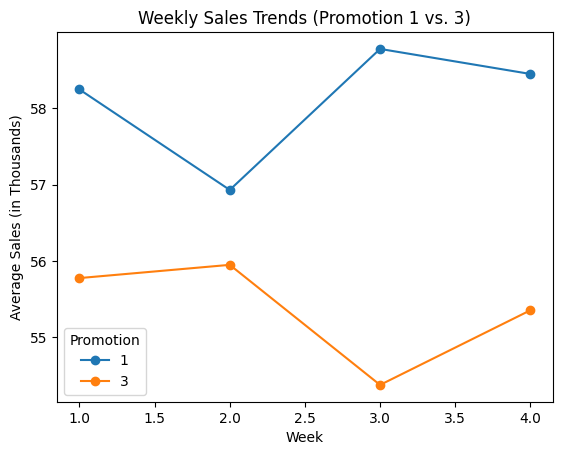

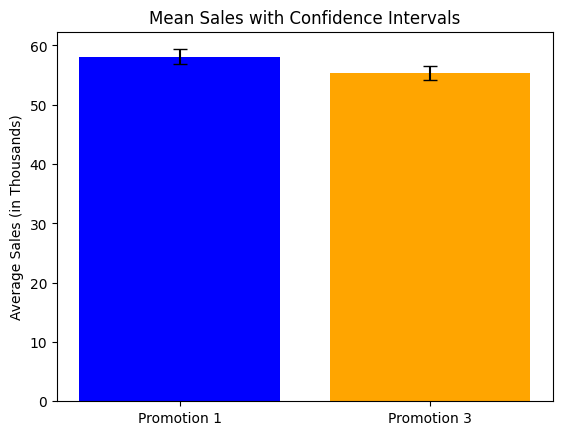

In [7]:
weekly_avg_sales.T.plot(
    kind="line",
    marker="o",
    title="Weekly Sales Trends (Promotion 1 vs. 3)",
    ylabel="Average Sales (in Thousands)",
)
plt.xlabel("Week")
plt.legend(title="Promotion")
plt.show()

mean_sales = [control.mean(), treatment.mean()]
errors = [
    control.std() / (len(control) ** 0.5),
    treatment.std() / (len(treatment) ** 0.5),
]
plt.bar(
    ["Promotion 1", "Promotion 3"],
    mean_sales,
    yerr=errors,
    capsize=5,
    color=["blue", "orange"],
)
plt.title("Mean Sales with Confidence Intervals")
plt.ylabel("Average Sales (in Thousands)")
plt.show()


## Recommendation
Based on the results:
- The p-value from the t-test indicates a statistically significant difference in sales between Promotion 1 and Promotion 3.
- Promotion 1 has a higher average sales compared to Promotion 3.
- The confidence intervals (both analytical and bootstrap) do not cross zero, supporting the conclusion that Promotion 1 is more effective.

**Recommendation**: Implement Promotion 1 as it is likely to result in higher sales.


## Future Improvements

- **Multi-factor analysis** to consider external factors affecting sales.

- **Seasonality adjustments** to control for time-based variations.